# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model


## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [ ]:
global device
device = torch.device("cuda:0")

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Its estimated that there are roughly 246 images per folder. Therefore, I decided that the
# splits should be:
# 172 images for training
# 49 images for validation
# 25 images for testing
# While the actual number of entries per folder does differ, I ensured that
# the size of the testing and validation data remained consistent throughout all
# files.

# counting number of files
import os

letter_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
type_list = ['training_data', 'validation_data', 'testing_data']

for data_type in type_list:
  for letter in letter_list:
    FOLDER_PATH = letter
    ROOT_PATH = '/content/drive/MyDrive/Lab3_Gestures_Summer/' + data_type + '/'
    print(data_type,letter,':',len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH))))

Mounted at /content/drive
training_data A : 177
training_data B : 170
training_data C : 168
training_data D : 170
training_data E : 170
training_data F : 159
training_data G : 173
training_data H : 167
training_data I : 172
validation_data A : 49
validation_data B : 49
validation_data C : 49
validation_data D : 49
validation_data E : 49
validation_data F : 49
validation_data G : 49
validation_data H : 49
validation_data I : 49
testing_data A : 25
testing_data B : 25
testing_data C : 25
testing_data D : 25
testing_data E : 25
testing_data F : 25
testing_data G : 25
testing_data H : 25
testing_data I : 25


In [ ]:
import torchvision.datasets as datasets

In [ ]:
# In order to split the dataset into three sub datasets for training, validation,
# and testing, I made three folders and split the data manually.
training_directory =  '/content/drive/MyDrive/Lab3_Gestures_Summer/training_data'
validation_directory = '/content/drive/MyDrive/Lab3_Gestures_Summer/validation_data'
testing_directory = '/content/drive/MyDrive/Lab3_Gestures_Summer/testing_data'

transformation_list = [transforms.Resize((224,224)), transforms.ToTensor()]
data_transformation = transforms.Compose(transformation_list)

training_data = datasets.ImageFolder(training_directory, data_transformation)
validation_data = datasets.ImageFolder(validation_directory, data_transformation)
testing_data = datasets.ImageFolder(testing_directory, data_transformation)

print("Number of training data images:", len(training_data)) # number of images in the training data set
print("Number of validation data images:", len(validation_data)) # number of images in the validation data set
print("Number of testing data images:", len(testing_data)) # number of images in the testing data set

Number of training data images: 1526
Number of validation data images: 441
Number of testing data images: 225


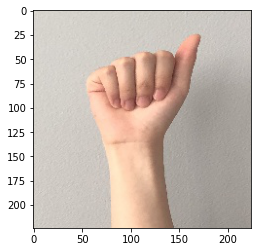

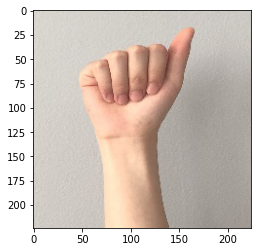

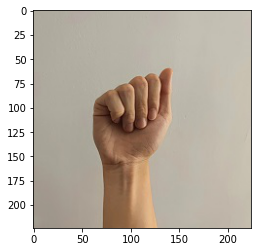

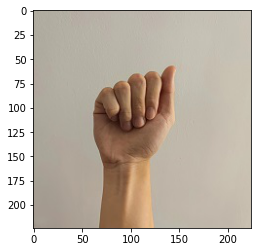

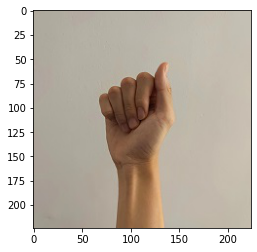

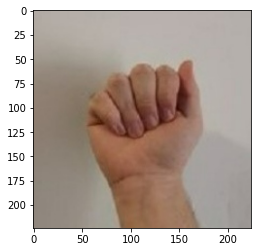

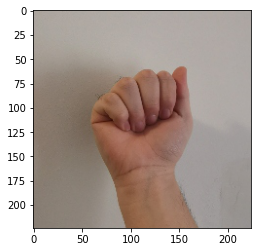

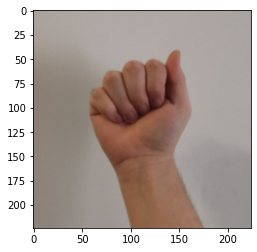

KeyboardInterrupt: ignored

In [ ]:
# Running a sample of the training data set to see if everything is loaded as intended
counter = 0
for i, (image, label) in enumerate(training_data):
  if counter <= 20:
    # convert the image to numpy array
    image = np.transpose(image.numpy(), (1, 2, 0))

    # plot the image
    plt.imshow(image)
    plt.show()
    counter += 1
  else:
    break

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
# General process for determining the size of each of the laters
# 1. input is going to be of size 3*224*224 as specified above, when this is passed through conv1, the size changes according to the formula:
# output_size = floor((input_size - kernel_size + 2 * padding) / stride) + 1 = [(224-5+0)/1] + 1 = 220, with the number of output channels equal to 5
# 2. The output is then passed through a max pooling layer where the size gets changed accordingly:
# output_size = 220/2 = 110
# 3. The output is then passed through conv2, where it changes size accordingly:
# output_size = [(110-5+0)/1]+1 = 106, making the new size 10*106*106
# 4. The output is then passed through another max pooling layer with kernel size 2 where the size changes:
# output_size = 106/2 = 53, making the size 10*53*53
# 5. The output determines the number of input neutrons, and 32 is decided as the number of outputs, as specified in the default code
# 6. Finally, the 32 outputs are put through another final fully connected layer where the CNN classifies the image into one of the 9 classes (A,B,C,D,E,F,G,H,I)
class Handsign_Net(nn.Module): # adjust some of the inputs and whatnot later
  def __init__(self):
        super(Handsign_Net, self).__init__()
        self.name = "handsign"
        self.conv1 = nn.Conv2d(3, 5, 5) # 3 input channels, 5 outputs channels, and a kernel size of 5x5, represents a 2D conv layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5) # 5 input channels to match the 5 output channels from conv1, 10 output channels, and a kernel size of 5x5
        self.fc1 = nn.Linear(10 * 53 * 53, 32) # num of input neurons is a product of output of conv2 (10) and the feature map (53x53)
        self.fc2 = nn.Linear(32, 9) # takes the 32 outputs from fc1 and classifies into the 9 different letters (classes)

  def forward(self, x):
  # ReLU activation function is applied to the convolutional layers and first fully connected layer to add non-linearity
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x
if torch.cuda.is_available:
  handsign_net = Handsign_Net().to(device)
else:
  handsign_net = Handsign_Net() # declare the cnn as an object

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
# Some functions meant for training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def get_accuracy_dataset(net, batch_size, dataloader):
  net.eval()
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    image, labels = data
    if torch.cuda.is_available():
        image = image.to(device)
        labels = labels.cuda(device)
    output = net(image)
    labels = normalize_label(labels)
    predicted_class = output.max(1, keepdim=True)[1]
    # Note that label represents the truth or correct answers and predicted_class are the models guesses/predictions
    correct = predicted_class.eq(labels.view_as(predicted_class)).sum().item() # calculates element-wise equality between predicted_class and label
    total = image.shape[0] # compute the total number of examples in the batch

  accuracy = correct/total

  return accuracy

# A function for training the model on the small dataset
def train_dataset(net, train_data, val_data, batch_size=27, learning_rate=0.001, num_epochs=30):
  device = torch.device("cuda:0")
  model = net.to(device)
  torch.manual_seed(1000)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
  criterion = nn.CrossEntropyLoss() # Did some research to find that cross entropy loss is a popular loss function choice for image classification
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)
  training_acc = []
  training_loss = []
  val_acc = []
  val_loss = []
  start_time = time.time()
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      for i, data in enumerate(train_loader,0):
          # Get the inputs
          inputs, labels = data
          if torch.cuda.is_available():
            inputs = inputs.to(device)
            labels = labels.cuda(device)
          # Zero the parameter gradients
          optimizer.zero_grad()
          # Forward pass, backward pass, and optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      train_acc = get_accuracy_dataset(net, batch_size, train_loader)
      avg_loss = float(loss)/batch_size
      validation_accuracy = val_stats_calc(net, val_loader, criterion)[1]
      validation_loss = val_stats_calc(net, val_loader, criterion)[0]

      training_acc.append(train_acc)
      training_loss.append(avg_loss)
      val_acc.append(validation_accuracy)
      val_loss.append(validation_loss)
      #print(("epoch {}: train accuracy: {} train loss: {}").format(epoch + 1, training_acc[-1], training_loss[-1]))
      print(("Epoch {}: Train Accuracy: {} Train Loss: {} |"+"Validation Accuracy: {} Validation Loss: {}").format(epoch + 1,training_acc[-1],training_loss[-1],val_acc[-1],val_loss[-1]))
      # Save the current model (checkpoint) to a file
      model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
      torch.save(net.state_dict(), model_path)

  # At this point, the model has finished training and the training time should be noted down
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  plt.title("Training Accuracy Curve")
  plt.plot(epochs, training_acc)
  plt.xlabel("Num Epochs")
  plt.ylabel("Training Accuracy")
  plt.show()

  plt.title("Training Loss Curve")
  plt.plot(epochs, training_loss)
  plt.xlabel("Num Epochs")
  plt.ylabel("Training loss")
  plt.show()

  plt.title("Validation Accuracy Curve")
  plt.plot(epochs, val_acc)
  plt.xlabel("Num Epochs")
  plt.ylabel("Training Accuracy")
  plt.show()

  plt.title("Validation Loss Curve")
  plt.plot(epochs, val_loss)
  plt.xlabel("Num Epochs")
  plt.ylabel("Training Accuracy")
  plt.show()

def val_stats_calc(net, loader, criterion):
  net.eval()
  with torch.no_grad():
    total_loss = 0.0
    total_error = 0.0
    for inputs, labels in iter(loader):
      if torch.cuda.is_available():
        inputs = inputs.to(device)
        labels = labels.cuda(device)
      outputs = net(inputs)
      loss = criterion(outputs, labels)

      total_loss += loss.item()
      total_error += (outputs.argmax(dim=1) != labels).sum().item()

  return (float(total_loss)/len(loader.dataset)), (1-total_error/len(loader.dataset))

def plot_training_curve(path):
  import matplotlib.pyplot as plt
  train_acc = np.loadtxt("{}_train_acc.csv".format(path))
  train_losses = np.loadtxt("{}_losses.csv".format(path))
  val_acc = np.loadtxt("{}_val_acc.csv".format(path))
  val_losses = np.loadtxt("{}_val_losses.csv".format(path))
  # Generating the training accuracy plot
  plt.title('Training Accuracy Curve')
  n = len(train_acc) # number of epochs
  plt.plot(range(1,n+1), train_acc, label="Training Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.show()
  # Generating the training loss plot
  plt.title('Training Loss Curve')
  plt.plot(range(1,n+1), train_losses, label="Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()
  # Generating the validation accuracy plot
  plt.title('Validation Accuracy Curve')
  plt.plot(range(1,n+1), val_acc, label="Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()
  # Generating the validation loss plot
  plt.title('Validation Loss Curve')
  plt.plot(range(1,n+1), val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

In [ ]:
def normalize_label(labels):
  max_val = torch.max(labels)
  min_val = torch.min(labels)
  norm_labels = (labels - min_val)/(max_val - min_val)
  scaled_labels = (norm_labels * 8).round().long()
  return scaled_labels

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
# Create a seperate folder containing the 'small' dataset and write code to access this file
from google.colab import drive
drive.mount('/content/drive')
small_directory = '/content/drive/MyDrive/Lab3_Gestures_Summer/small_dataset/'
transformation_list = [transforms.Resize((224,224)), transforms.ToTensor()]
data_transformation = transforms.Compose(transformation_list)
small_dataset = datasets.ImageFolder(small_directory, data_transformation)
small_net = Handsign_Net()

In [ ]:
# Train the model on the small dataset
small_net = Handsign_Net()
train_dataset(small_net, small_dataset, validation_data, num_epochs=100)
# plot the performance

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
# Based on the results of lab 2, three hyperparameters I would look further into would be
# batch size, learning rate, and potentially the number of layers in the CNN

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
net1 = Handsign_Net()
train_dataset(net1, training_data, validation_data, batch_size = 256, learning_rate = 0.01, num_epochs=30)

In [ ]:
net2 = Handsign_Net()
train_dataset(net2, training_data, validation_data, batch_size=64, learning_rate=0.001, num_epochs=30)

In [ ]:
net3 = Handsign_Net()
train_dataset(net3, training_data, validation_data, batch_size=64, learning_rate=0.005, num_epochs=30)

In [ ]:
net5 = Handsign_Net()
train_dataset(net5, training_data, validation_data, batch_size=256, learning_rate=0.001, num_epochs=30)

In [ ]:
# Change the number of layers
class Handsign_Net_New(nn.Module): # adjust some of the inputs and whatnot later
  def __init__(self):
        super(Handsign_Net_New, self).__init__()
        self.name = "handsign_new"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 9)

  def forward(self, x):
  # ReLU activation function is applied to the convolutional layers and first fully connected layer to add non-linearity
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

if torch.cuda.is_available:
  handsign_net_new = Handsign_Net_New().to(device)
else:
  handsign_net_new = Handsign_Net_New() # declare the cnn as an object

net4 = Handsign_Net_New()
train_dataset(net4, training_data, validation_data, batch_size=64, learning_rate=0.001, num_epochs=30)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
# The best model was the new CNN model with a batch_size of 64, learning_rate of 0.001, and num_epoch of 30.
# The new CNN model scored the highest with the original epoch number of 30, but the model scored fairly high
# when it was trained using an epoch number of 6.Furthermore, its graph showed the steadiest increase in
# accuracy with very little fluctuations in the accuracy for both the validation and training data sets.
# Therefore, I decided to combine the new CNN model with the new num_epochs of 30.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
def get_accuracy_dataset(net, batch_size, dataloader):
  net.eval()
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    image, labels = data
    if torch.cuda.is_available():
        image = image.to(device)
        labels = labels.cuda(device)
    output = net(image)
    labels = normalize_label(labels)
    predicted_class = output.max(1, keepdim=True)[1]
    # Note that label represents the truth or correct answers and predicted_class are the models guesses/predictions
    correct = predicted_class.eq(labels.view_as(predicted_class)).sum().item() # calculates element-wise equality between predicted_class and label
    total = image.shape[0] # compute the total number of examples in the batch

  accuracy = correct/total

  return accuracy

# A function for training the model on the small dataset
def train_dataset_test(net, test_data, batch_size=64, learning_rate=0.001, num_epochs=30):
  device = torch.device("cuda:0")
  model = net.to(device)
  torch.manual_seed(1000)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
  criterion = nn.CrossEntropyLoss() # Did some research to find that cross entropy loss is a popular loss function choice for image classification
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)
  test_acc = []
  start_time = time.time()
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      for i, data in enumerate(test_loader,0):
          # Get the inputs
          inputs, labels = data
          if torch.cuda.is_available():
            inputs = inputs.to(device)
            labels = labels.cuda(device)
          # Zero the parameter gradients
          optimizer.zero_grad()
          # Forward pass, backward pass, and optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      testing_acc = get_accuracy_dataset(net, batch_size, test_loader)

      test_acc.append(testing_acc)
      model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
      torch.save(net.state_dict(), model_path)

  # At this point, the model has finished training and the training time should be noted down
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  print("Final Training Accuracy:", test_acc[-1])
  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  plt.title("Testing Accuracy Curve")
  plt.plot(epochs, test_acc)
  plt.xlabel("Num Epochs")
  plt.ylabel("Testing Accuracy")
  plt.show()

In [ ]:
new_net = Handsign_Net_New()
train_dataset_test(new_net, testing_data)

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
import os
features_path = '/content/drive/MyDrive/Lab3_Gestures_Summer/transfer_data'
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

batch_size = 1
num_workers = 1

# Saves tensors for training data
transfer_train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
transfer_validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
transfer_test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loader_list = [transfer_train_dataloader, transfer_validation_dataloader, transfer_test_dataloader]

for loader in loader_list:
  if loader == transfer_train_dataloader:
    x = 0
    for images, labels in loader:
      features = alexnet.features(images)
      featuresTensor = torch.from_numpy(features.detach().numpy())

      folder = features_path + '/training/' + str(classes[labels])
      if not os.path.isdir(folder):
        os.mkdir(folder)
      torch.save(featuresTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
      x += 1
  elif loader == transfer_validation_dataloader:
    x = 0
    for images, labels in loader:
      features = alexnet.features(images)
      featuresTensor = torch.from_numpy(features.detach().numpy())

      folder = features_path + '/validation/' + str(classes[labels])
      if not os.path.isdir(folder):
        os.mkdir(folder)
      torch.save(featuresTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
      x += 1
  elif loader == transfer_test_dataloader:
    x = 0
    for images, labels in loader:
      features = alexnet.features(images)
      featuresTensor = torch.from_numpy(features.detach().numpy())

      folder = features_path + '/testing/' + str(classes[labels])
      if not os.path.isdir(folder):
        os.mkdir(folder)
      torch.save(featuresTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
      x += 1

In [ ]:
train_features = torchvision.datasets.DatasetFolder(features_path + '/training', loader=torch.load, extensions=('.tensor'))
validation_features = torchvision.datasets.DatasetFolder(features_path + '/validation', loader=torch.load, extensions=('.tensor'))
test_features = torchvision.datasets.DatasetFolder(features_path + '/testing', loader=torch.load, extensions=('.tensor'))

train_features_load = torch.utils.data.DataLoader(train_features, batch_size=32, num_workers=1, shuffle=True)
validation_features_load = torch.utils.data.DataLoader(validation_features, batch_size=32, num_workers=1, shuffle=True)
test_features_load = torch.utils.data.DataLoader(test_features, batch_size=32, num_workers=1, shuffle=True)

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
#output = model(features)
#prob = F.softmax(output)

# I wanted to keep the general architecture of the new CNN the same, so I decided to maintain the same number of convolutional layers
# as well as fully connected layers. I did change the number of input channels to 256 for the first convolutional layer
# to better match this application with the preset weights. Furthermore, I decided to use the same activation function of ReLu since it
# is extremely well tailored for image recognition tasks due to its ability to understand non-linear relationships between the inputs and the outputs.

class AlexNet_CNN(nn.Module):
    def __init__(self):
        super(AlexNet_CNN, self).__init__()
        self.name = "alexnet_cnn"
        self.conv1 = nn.Conv2d(256, 64, 2)
        self.conv2 = nn.Conv2d(64, 10, 2)
        self.fc1 = nn.Linear(10*4*4, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 10*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
train_transferdata = torchvision.datasets.DatasetFolder('/content/drive/MyDrive/Lab3_Gestures_Summer/transfer_data/training', loader=torch.load, extensions=('.tensor'))
val_transferdata = torchvision.datasets.DatasetFolder('/content/drive/MyDrive/Lab3_Gestures_Summer/transfer_data/validation', loader=torch.load, extensions=('.tensor'))
test_transferdata = torchvision.datasets.DatasetFolder('/content/drive/MyDrive/Lab3_Gestures_Summer/transfer_data/testing', loader=torch.load, extensions=('.tensor'))

# Some functions meant for training
def get_model_name_transfer(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label_transfer(labels):
  max_val = torch.max(labels)
  min_val = torch.min(labels)
  norm_labels = (labels - min_val)/(max_val - min_val)
  scaled_labels = (norm_labels * 8).round().long()
  return scaled_labels

def get_accuracy_dataset_transfer(net, batch_size, dataloader):
  net.eval()
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    image, labels = data
    if torch.cuda.is_available():
        image = image.to(device)
        labels = labels.cuda(device)
    output = net(image)
    labels = normalize_label(labels)
    predicted_class = output.max(1, keepdim=True)[1]
    # Note that label represents the truth or correct answers and predicted_class are the models guesses/predictions
    correct = predicted_class.eq(labels.view_as(predicted_class)).sum().item() # calculates element-wise equality between predicted_class and label
    total = image.shape[0] # compute the total number of examples in the batch

  accuracy = correct/total

  return accuracy

# A function for training the model on the small dataset
def train_dataset_transfer(net, train_data, val_data, batch_size=27, learning_rate=0.001, num_epochs=30):
  device = torch.device("cuda:0")
  model = net.to(device)
  torch.manual_seed(1000)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
  criterion = nn.CrossEntropyLoss() # Did some research to find that cross entropy loss is a popular loss function choice for image classification
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)
  training_acc = []
  training_loss = []
  val_acc = []
  val_loss = []
  start_time = time.time()
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      for i, data in enumerate(train_loader,0):
          # Get the inputs
          inputs, labels = data
          if torch.cuda.is_available():
            inputs = inputs.to(device)
            labels = labels.cuda(device)
          # Zero the parameter gradients
          optimizer.zero_grad()
          # Forward pass, backward pass, and optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      train_acc = get_accuracy_dataset_transfer(net, batch_size, train_loader)
      avg_loss = float(loss)/batch_size
      validation_accuracy = val_stats_calc(net, val_loader, criterion)[1]
      validation_loss = val_stats_calc(net, val_loader, criterion)[0]

      training_acc.append(train_acc)
      training_loss.append(avg_loss)
      val_acc.append(validation_accuracy)
      val_loss.append(validation_loss)
      #print(("epoch {}: train accuracy: {} train loss: {}").format(epoch + 1, training_acc[-1], training_loss[-1]))
      print(("Epoch {}: Train Accuracy: {} Train Loss: {} |"+"Validation Accuracy: {} Validation Loss: {}").format(epoch + 1,training_acc[-1],training_loss[-1],val_acc[-1],val_loss[-1]))
      # Save the current model (checkpoint) to a file
      model_path = get_model_name_transfer(net.name, batch_size, learning_rate, epoch)
      torch.save(net.state_dict(), model_path)

  # At this point, the model has finished training and the training time should be noted down
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  plt.title("Training Accuracy Curve")
  plt.plot(epochs, training_acc)
  plt.xlabel("Num Epochs")
  plt.ylabel("Training Accuracy")
  plt.show()

  plt.title("Training Loss Curve")
  plt.plot(epochs, training_loss)
  plt.xlabel("Num Epochs")
  plt.ylabel("Training loss")
  plt.show()

  plt.title("Validation Accuracy Curve")
  plt.plot(epochs, val_acc)
  plt.xlabel("Num Epochs")
  plt.ylabel("Training Accuracy")
  plt.show()

  plt.title("Validation Loss Curve")
  plt.plot(epochs, val_loss)
  plt.xlabel("Num Epochs")
  plt.ylabel("Training Accuracy")
  plt.show()

def val_stats_calc(net, loader, criterion):
  net.eval()
  with torch.no_grad():
    total_loss = 0.0
    total_error = 0.0
    for inputs, labels in iter(loader):
      if torch.cuda.is_available():
        inputs = inputs.to(device)
        labels = labels.cuda(device)
      outputs = net(inputs)
      loss = criterion(outputs, labels)

      total_loss += loss.item()
      total_error += (outputs.argmax(dim=1) != labels).sum().item()

  return (float(total_loss)/len(loader.dataset)), (1-total_error/len(loader.dataset))

In [ ]:
transfer_model = AlexNet_CNN()
train_dataset_transfer(transfer_model, train_transferdata, val_transferdata, batch_size=64, learning_rate=0.001, num_epochs=30)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

Finished Training
Total time elapsed: 0.79 seconds
Final Training Accuracy: 1.0


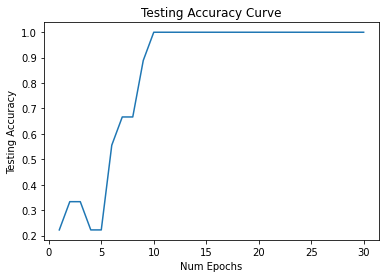

In [ ]:
new_transfer_net = AlexNet_CNN()
train_dataset_test(new_transfer_net, test_transferdata)

In [ ]:
# The test accuracy score for the AlexNet CNN was 1.0, compared to the testing accuracy score of 0.93939 achieved with the original CNN.

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
# The best features included the AlexNet CNN, a batch size of 64, a learning rate of 0.001, epoch number of 30
final_model = AlexNet_CNN()
compare_model = Handsign_Net_New()
final_path = '/content/drive/MyDrive/Lab3_Gestures_Summer/final_test_data'

transformation_list = [transforms.Resize((224,224)), transforms.ToTensor()]
data_transformation = transforms.Compose(transformation_list)

final_data = datasets.ImageFolder(final_path, data_transformation)
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

batch_size = 1
num_workers = 1
features_path = '/content/drive/MyDrive/Lab3_Gestures_Summer/transfer_data'
final_dataloader = torch.utils.data.DataLoader(final_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
x = 0
# creating the feature tensors
for images, labels in loader:
  features = alexnet.features(images)
  featuresTensor = torch.from_numpy(features.detach().numpy())

  folder = features_path + '/final/' + str(classes[labels])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featuresTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  x += 1

final_features = torchvision.datasets.DatasetFolder(features_path + '/final', loader=torch.load, extensions=('.tensor'))
final_features_load = torch.utils.data.DataLoader(final_features, batch_size=64, num_workers=1, shuffle=True)
final_transferdata = torchvision.datasets.DatasetFolder('/content/drive/MyDrive/Lab3_Gestures_Summer/transfer_data/final', loader=torch.load, extensions=('.tensor'))

In [ ]:
train_dataset_test(final_model, final_transferdata)

NameError: ignored

In [ ]:
train_dataset_test(compare_model, final_data)

In [ ]:
# In the end, the new AlexNet CNN did much better on the final test data, scoring an accuracy score of 1.0
# while the new CNN developed in the previous parts got an accuracy score of 0.8148. I predict that the AlexNet CNN
# did much better since it has been developed by professionals in the field and won a competition. I would say that
# the reasoning behind my model's lesser accuracy would be a combination of poor hyperparameter tuning on my end, which
# would have resulted from not testing enough. While I did run a number of tests with different hyperparameter pairings,
# I still did not explore all possibilities. Another issue could be stemming from overfitting to training data.